In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import nltk
import gensim
import openai
from dotenv import load_dotenv
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

In [3]:
df = pd.read_csv('../data_clean/merged_total_no_keyphrases.csv')
# df.fillna('unknown', inplace=True)
df.shape

(250666, 56)

### Embedding

In [3]:
load_dotenv("../.env")
openai.api_key = os.getenv("OPENAI_API_KEY")

embedding_model = "text-embedding-ada-002"

nltk.download('stopwords')
nltk.download('punkt')

In [4]:
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols = cat_cols[(cat_cols != 'contact_contactpersoon_id') & (cat_cols != 'account_account_id') & (cat_cols != 'campagne_campagne_id')]

cat_cols

Index(['afspraak_keyphrases', 'account_keyphrases', 'campagne_keyphrases',
       'sessie_keyphrases', 'visit_keyphrases', 'mailing_keyphrases'],
      dtype='object')

In [5]:
def remove_stopwords(text):
    stop_words_nl = set(stopwords.words('dutch'))
    
    word_tokens = word_tokenize(text, language='dutch')

    result = [x for x in word_tokens if x not in stop_words_nl]

    seperator = ', '
    return seperator.join(result)


def team_name_change(text):
    teams_dict = {
        'jo': ' jong ondernemen ',
        'do': ' duurzaam ondernemen ',
        'in': ' innovatie digitalisering ',
        'io': ' internationaal ondernemen ',
        'ao': ' arbeidsmarkt ',
        'ex': ' expert ',
        'gr': ' groei ',
        'bb': ' belangenbehartiging ',
        'co': ' communicatie ',
        'nw': ' netwerking ',
        'ha': ' haven ',
        'ma': ' match '
    }
    word_tokens = word_tokenize(text, language='dutch')
    # apply dict to list
    result = [teams_dict.get(word, word) for word in word_tokens]
    # join list to string
    cleaned_list = ', '.join(result)
    # tokenize string
    tokenize_list = word_tokenize(cleaned_list, language='dutch')
    # remove comma
    tokenize_list_no_comma = [x for x in tokenize_list if x != ',']
    # join list to string and remove duplicates from list
    return ', '.join(list(set(tokenize_list_no_comma)))


def stemmer(text):
    stemmer = SnowballStemmer(language='dutch')
    stem_sentence=[]
    for word in text.split(','):
        stem_sentence.append(stemmer.stem(word))
    stem_sentence= ', '.join(stem_sentence)
    return stem_sentence



def clean_text(df, cat_cols=cat_cols):

    df_copy = df.copy()

    for col in cat_cols:
        for row in range(len(df_copy)):
            name_change = team_name_change(df_copy[col][row])
            no_stopwords = remove_stopwords(name_change)
            tokenize_list = word_tokenize(no_stopwords, language='dutch')
            tokenize_list = [x for x in tokenize_list if x != ',']
            df_copy.at[row, col] = ', '.join(list(set(tokenize_list)))
            stemmer_list= stemmer(df_copy[col][row])
            df_copy.at[row, col] = stemmer_list
            
    return df_copy

duurt 13 minuten om df_clean te maken (10cores) 30 min (4cores)

In [6]:
df_clean = clean_text(df=df, cat_cols=cat_cols)

In [7]:
del df

In [8]:
for col in cat_cols:
    df_clean[col] = df_clean[col].str.replace(r'\d', '', regex=True).str.replace(', ,', ',').str.replace(r'(\s{2},\s{2}),*+', '', regex=True) \
        .str.replace('  ', ' ')
    df_clean[col] = df_clean[col].apply(lambda x: 'unknown' if len(x) == 0 else x)

In [11]:
def get_embedding(text):
    response = openai.Embedding.create(
    input=text,
    model=embedding_model
    )   
    return response['data'][0]['embedding']


def embed_col(dataframe, col):
    # create copy of dataframe
    df_clean_embed = dataframe.copy()
    
    # create unique list of values
    unique_col = df_clean_embed[col].unique().tolist()

    # create dict with values and embeddings
    dict_temp = {}
    for i in unique_col:
        dict_temp[i] = get_embedding(i)

    # map dict to column
    df_clean_embed[col+'_embed'] = df_clean_embed[col].map(dict_temp)

    # drop original column
    df_clean_embed.drop(columns=[col], inplace=True)

    # reduce vectors to 1 dimension
    df_clean_embed[col+'_embed'] = df_clean_embed[col+'_embed'].apply(lambda x: np.mean(x, axis=0))

    return df_clean_embed

Campagne_keyphrases_embeddings: 6.5 minuten

In [12]:
df_clean_embed = embed_col(dataframe=df_clean, col='campagne_keyphrases')

In [13]:
del df_clean

Afspraak_keyphrases_embeddings: 11.5 minuten

In [14]:
df_clean_embed = embed_col(dataframe=df_clean_embed, col='afspraak_keyphrases')

Account_keyphrases_embeddings: 41.5 minuten

In [15]:
df_clean_embed = embed_col(dataframe=df_clean_embed, col='account_keyphrases')

Sessie_keyphrases_embeddings: 2 minuten

In [16]:
df_clean_embed = embed_col(dataframe=df_clean_embed, col='sessie_keyphrases')

Visit_keyphrases_embeddings: 53.2 minuten

In [17]:
df_clean_embed = embed_col(dataframe=df_clean_embed, col='visit_keyphrases')

Mailing_keyphrases_embeddings: 2.5 minuten

In [18]:
df_clean_embed = embed_col(dataframe=df_clean_embed, col='mailing_keyphrases')

In [21]:
df_clean_embed.shape

(250666, 37)

In [20]:
df_clean_embed.to_csv('../data_clean/merged_total_embed.csv', index=False)

### CLUSTERING

Als een key user kan ik voor een campagne een lijst met contacten genereren volgens de waarschijnlijkheid om in te schrijven voor de campagne. Ik wil in de sortering ook ervoor zorgen dat contacten met weinig marketing pressure bevoordeeld worden ten opzichte van contacten met een hoge marketing pressure.

#### K-MEANS

In [45]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import seaborn as sns

In [2]:
data = pd.read_csv('../data_clean/merged_total_embed.csv')
data.shape

(250666, 37)

In [12]:
X = data.drop(columns=['contact_contactpersoon_id', 'campagne_campagne_id'], axis=1)
labels = data[['campagne_campagne_id', 'contact_contactpersoon_id']]

X.shape, labels.shape

In [15]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

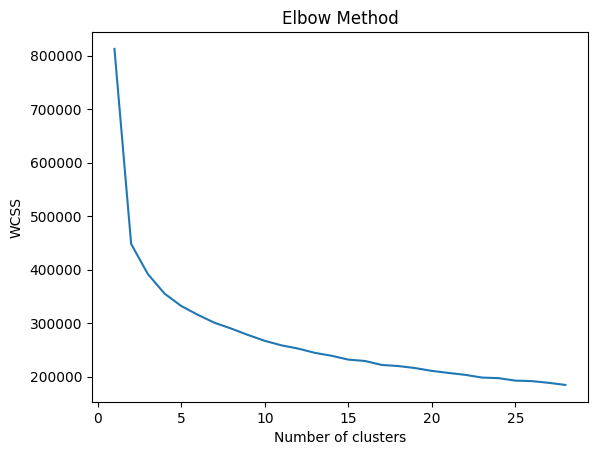

In [26]:
wcss = []

for i in range(1, 29):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 29), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [40]:
n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
kmeans.fit(X_train)

y_pred = kmeans.predict(X_test)
y_pred, len(y_pred)

(array([0, 1, 1, ..., 0, 0, 0]), 50134)

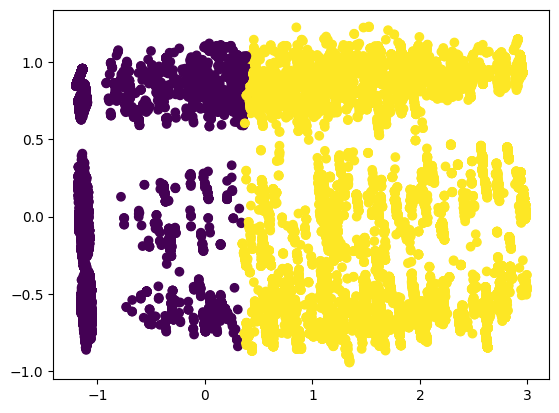

In [41]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)

In [42]:
silhouette_score(X_test, y_pred)

0.45307655739424046

Silhouette score 0.453 --> aantal clusters 2

Silhouette score 0.403 --> aantal clusters 3

Silhouette score 0.2411 --> aantal clusters 4

In [58]:
clustered_data = pd.DataFrame({'cluster': y_pred, 'campagne': y_test['campagne_campagne_id'], 'contact': y_test['contact_contactpersoon_id']})

#### K-NN

In [75]:
# KNN
from sklearn.neighbors import NearestNeighbors

In [76]:
data = pd.read_csv('../data_clean/merged_total_embed.csv')
data.shape

(250666, 37)

In [77]:
X = data.drop(columns=['contact_contactpersoon_id', 'campagne_campagne_id'], axis=1)
labels = data[['campagne_campagne_id', 'contact_contactpersoon_id']]

X.shape, labels.shape

((250666, 35), (250666, 2))

In [78]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((200532, 35), (50134, 35), (200532, 2), (50134, 2))